In [88]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import wordnet
import random
import warnings
warnings.filterwarnings("ignore")

# HuggingFace imports
from transformers import AutoTokenizer, AutoConfig, AutoModel
from datasets import load_dataset

# Captum imports for Integrated Gradients
from captum.attr import IntegratedGradients, visualization as viz
from captum.attr import TokenReferenceBase, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [89]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

🔧 Using device: cuda


## Model Architecture

In [ ]:
class BERTweetSingleTaskTransformer(nn.Module):
    
    def __init__(
        self,
        model_name: str = "vinai/bertweet-base",
        num_classes: int = 3,
        hidden_dropout_prob: float = 0.1,
        attention_dropout_prob: float = 0.1,
        classifier_dropout: float = 0.1
    ):
        super(BERTweetSingleTaskTransformer, self).__init__()
        
        self.model_name = model_name
        self.num_classes = num_classes
        
        # Load BERTweet configuration
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = attention_dropout_prob
        
        # BERTweet encoder
        self.encoder = AutoModel.from_pretrained(model_name, config=config)
        
        hidden_size = self.encoder.config.hidden_size
        
        # Classification head optimized for BERTweet
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize classification head weights"""
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, input_ids, attention_mask):
        encoder_outputs = self.encoder(
            input_ids=input_ids.long(),
            attention_mask=attention_mask,
            return_dict=True
        )
        
        pooled_output = encoder_outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        
        return {'logits': logits}
    
    @classmethod
    def from_pretrained(cls, model_path: str, **kwargs):
        import torch
        import json
        import os

        # Load saved config
        config_path = os.path.join(model_path, "config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)

        # Initialize model architecture
        model = cls(
            model_name=config["model_name"],
            num_classes=config["num_classes"],
            **kwargs
        )

        # Load state dict from HuggingFace-style checkpoint
        model_file = os.path.join(model_path, "pytorch_model.bin")
        state_dict = torch.load(model_file, map_location='cpu')

        # Rename keys if they use HuggingFace format (e.g., "bertweet.")
        renamed_state_dict = {}
        for k, v in state_dict.items():
            new_k = k
            if k.startswith("bertweet."):
                new_k = k.replace("bertweet.", "encoder.")
            renamed_state_dict[new_k] = v

        model.load_state_dict(renamed_state_dict, strict=False)

        return model


In [ ]:
class BERTweetMultiTaskTransformer(nn.Module):
    
    def __init__(
        self,
        model_name: str = "vinai/bertweet-base",
        sentiment_num_classes: int = 3,
        emotion_num_classes: int = 6,
        hidden_dropout_prob: float = 0.1,
        attention_dropout_prob: float = 0.1,
        classifier_dropout: float = 0.1
    ):
        super(BERTweetMultiTaskTransformer, self).__init__()
        
        self.model_name = model_name
        self.sentiment_num_classes = sentiment_num_classes
        self.emotion_num_classes = emotion_num_classes
        
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = attention_dropout_prob
        
        # Shared BERTweet encoder
        self.shared_encoder = AutoModel.from_pretrained(model_name, config=config)
        
        hidden_size = self.shared_encoder.config.hidden_size
        
        # Sentiment classification head
        self.sentiment_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, sentiment_num_classes)
        )

        # Emotion classification head
        self.emotion_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, emotion_num_classes)
        )
   
        self._init_weights()
    
    def _init_weights(self):
        for classifier in [self.sentiment_classifier, self.emotion_classifier]:
            for layer in classifier:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.zeros_(layer.bias)
    
    def forward(self, input_ids, attention_mask):
        # Shared encoder
        encoder_outputs = self.shared_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        cls_output = encoder_outputs.last_hidden_state[:, 0, :]     # [batch, 768]
        pooled_output = encoder_outputs.pooler_output               # [batch, 768]

        combined = torch.cat((cls_output, pooled_output), dim=1)    # [batch, 1536]

        # Task-specific predictions
        sentiment_logits = self.sentiment_classifier(combined)
        emotion_logits = self.emotion_classifier(combined)
        
        return {
            'sentiment_logits': sentiment_logits,
            'emotion_logits': emotion_logits
        }
    
    @classmethod
    def from_pretrained(cls, model_path: str, **kwargs):
        import torch
        import json
        from transformers import AutoModel

        # Load saved config
        config_path = os.path.join(model_path, "config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)

        # Initialize model with architecture info
        model = cls(
            model_name=config["model_name"],
            sentiment_num_classes=config["sentiment_num_classes"],
            emotion_num_classes=config["emotion_num_classes"],
            **kwargs
        )

        # Load HuggingFace-style state dict (actual weights)
        model_file = os.path.join(model_path, "pytorch_model.bin")
        state_dict = torch.load(model_file, map_location='cpu')

        # Handle HuggingFace checkpoint key mismatch
        renamed_state_dict = {}
        for k, v in state_dict.items():
            new_k = k
            if k.startswith("bertweet."):
                new_k = k.replace("bertweet.", "encoder.")
            renamed_state_dict[new_k] = v

        model.load_state_dict(renamed_state_dict, strict=False)

        return model



## Model Loading

In [ ]:
def load_bertweet_models(
    single_task_path: str = "./bertweet_trained_models_seeds/bertweet_sentiment_seed_42",
    multitask_path: str = "./bertweet_trained_models_seeds/bertweet_multitask_seed_42"
) -> Tuple[Dict, Dict]:

    print("🔄 Loading BERTweet models...")
    
    # Load single-task model
    print(f"📥 Loading single-task model from {single_task_path}")
    single_task_model = BERTweetSingleTaskTransformer.from_pretrained(single_task_path)
    single_task_model.to(device)
    single_task_model.eval()
    
    # Load tokenizer for single-task
    single_task_tokenizer = AutoTokenizer.from_pretrained(single_task_path)
    if single_task_tokenizer.pad_token is None:
        single_task_tokenizer.pad_token = single_task_tokenizer.eos_token
    
    # Load label encoder for single-task
    single_task_encoder = joblib.load(os.path.join(single_task_path, 'sentiment_encoder.pkl'))
    
    # Load multitask model
    print(f"📥 Loading multitask model from {multitask_path}")
    multitask_model = BERTweetMultiTaskTransformer.from_pretrained(multitask_path)
    multitask_model.to(device)
    multitask_model.eval()
    
    # Load tokenizer for multitask
    multitask_tokenizer = AutoTokenizer.from_pretrained(multitask_path)
    if multitask_tokenizer.pad_token is None:
        multitask_tokenizer.pad_token = multitask_tokenizer.eos_token
    
    # Load label encoders for multitask
    multitask_sentiment_encoder = joblib.load(os.path.join(multitask_path, 'sentiment_encoder.pkl'))
    
    single_task_dict = {
        'model': single_task_model,
        'tokenizer': single_task_tokenizer,
        'sentiment_encoder': single_task_encoder,
        'type': 'single_task'
    }
    
    multitask_dict = {
        'model': multitask_model,
        'tokenizer': multitask_tokenizer,
        'sentiment_encoder': multitask_sentiment_encoder,
        'type': 'multitask'
    }
    
    print("✅ Models loaded successfully!")
    return single_task_dict, multitask_dict


In [ ]:
def load_test_examples(data_path: str = "data/cleaned_reddit_posts.csv", num_examples: int = 10) -> List[str]:

    print(f"📊 Loading {num_examples} test examples from {data_path}")
    
    if data_path.endswith('.csv'):
        df = pd.read_csv(data_path)
        texts = df['text_content'].head(num_examples).tolist()
    else:
        # Handle JSON files if needed
        with open(data_path, 'r') as f:
            data = json.load(f)
        texts = [item['text'] for item in data[:num_examples]]
    
    # Clean and filter texts
    cleaned_texts = []
    for text in texts:
        if isinstance(text, str) and len(text.strip()) > 10:
            # Basic cleaning
            cleaned_text = text.strip()
            if len(cleaned_text.split()) >= 5:  # At least 5 words
                cleaned_texts.append(cleaned_text)
        
        if len(cleaned_texts) >= num_examples:
            break
    
    print(f"✅ Loaded {len(cleaned_texts)} valid test examples")
    return cleaned_texts


## IG Generation

In [ ]:
class BERTweetIntegratedGradients:
    
    def __init__(self):
        self.baseline_token_id = 0  # [PAD] token
        
    def _create_forward_function(self, model, task='sentiment'):
        
        def forward_fn(embeddings, attention_mask=None):
            # embeddings: [batch_size, seq_len, embedding_dim]
            # attention_mask: [batch_size, seq_len]
            
            model.eval()
            
            if hasattr(model, 'shared_encoder'):  # Multitask model
                # For multitask model, we need to manually forward through the encoder
                encoder_outputs = model.shared_encoder(
                    inputs_embeds=embeddings,
                    attention_mask=attention_mask,
                    return_dict=True
                )
                
                cls_output = encoder_outputs.last_hidden_state[:, 0, :]
                pooled_output = encoder_outputs.pooler_output
                combined = torch.cat((cls_output, pooled_output), dim=1)
                sentiment_logits = model.sentiment_classifier(combined)
                return sentiment_logits
            else:  # Single task model
                # For single-task model
                encoder_outputs = model.encoder(
                    inputs_embeds=embeddings,
                    attention_mask=attention_mask,
                    return_dict=True
                )
                pooled_output = encoder_outputs.last_hidden_state[:, 0, :]
                logits = model.classifier(pooled_output)
                return logits
        
        return forward_fn
    
    def _get_embedding_layer(self, model):
        if hasattr(model, 'shared_encoder'):  # Multitask model
            return model.shared_encoder.embeddings.word_embeddings
        else:  # Single task model
            return model.encoder.embeddings.word_embeddings
    
    def generate_attributions(
            self, 
            text: str, 
            model_dict: Dict, 
            max_length: int = 128,
            n_steps: int = 25
        ) -> Dict[str, Any]:
            model = model_dict['model']
            tokenizer = model_dict['tokenizer']
            
            print(f"🔍 Generating IG attributions for {model_dict['type']} model...")
            
            # Ensure model is in eval mode
            model.eval()
            
            # Tokenize input
            inputs = tokenizer(
                text, 
                return_tensors="pt", 
                truncation=True, 
                padding=True,
                max_length=max_length
            )
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            
            # Get embedding layer
            embedding_layer = self._get_embedding_layer(model)
            
            # Convert input_ids to embeddings
            input_embeddings = embedding_layer(input_ids)  # [batch_size, seq_len, embedding_dim]
            
            # Create baseline (zero embeddings)
            baseline_embeddings = torch.zeros_like(input_embeddings)
            
            # Get predicted class first
            forward_fn = self._create_forward_function(model, 'sentiment')
            model.eval()
            with torch.no_grad():
                temp_outputs = forward_fn(input_embeddings, attention_mask)
                predictions = F.softmax(temp_outputs, dim=-1)
                predicted_class = torch.argmax(predictions, dim=-1).item()
                confidence = predictions.max().item()
            
            print(f"🎯 Predicted class: {predicted_class}, Confidence: {confidence:.3f}")
            
            # Try Integrated Gradients with embeddings
            try:
                print("🔄 Computing Integrated Gradients with embeddings...")
                
                # Create a wrapper function that only takes embeddings as input
                def embedding_forward_fn(embeddings):
                    return forward_fn(embeddings, attention_mask)
                
                # Initialize Integrated Gradients
                ig = IntegratedGradients(embedding_forward_fn)
                
                # Compute attributions
                attributions, convergence_delta = ig.attribute(
                    inputs=input_embeddings,
                    baselines=baseline_embeddings,
                    target=predicted_class,
                    n_steps=n_steps,
                    return_convergence_delta=True,
                    internal_batch_size=1
                )
                
                print("✅ Integrated Gradients computation succeeded!")
                
            except Exception as e:
                print(f"❌ Integrated Gradients failed: {e}")
                
                # Fallback: Simple gradient method
                try:
                    print("🔄 Fallback: Simple gradient method...")
                    
                    # Enable gradients for input embeddings
                    input_embeddings_grad = input_embeddings.clone().detach().requires_grad_(True)
                    
                    # Forward pass
                    logits = forward_fn(input_embeddings_grad, attention_mask)
                    target_logit = logits[0, predicted_class]
                    
                    # Backward pass
                    model.zero_grad()
                    target_logit.backward()
                    
                    # Get gradients as attributions
                    attributions = input_embeddings_grad.grad
                    convergence_delta = torch.tensor(0.0)
                    
                    print("✅ Simple gradient method succeeded!")
                    
                except Exception as e2:
                    print(f"❌ All methods failed: {e2}")
                    print("🔄 Using random attributions for debugging...")
                    
                    # Random fallback
                    attributions = torch.randn_like(input_embeddings)
                    convergence_delta = torch.tensor(0.0)
            
            # Process the attribution results
            try:
                # Get tokens
                tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
                
                # Sum attribution scores across embedding dimensions
                if attributions.dim() == 3:  # [batch_size, seq_len, embedding_dim]
                    attribution_scores = attributions.sum(dim=-1).squeeze().cpu().detach().numpy()
                else:
                    attribution_scores = attributions.squeeze().cpu().detach().numpy()
                
                # Ensure we have the right number of scores
                if len(attribution_scores.shape) == 0:  # scalar
                    attribution_scores = np.array([attribution_scores])
                
                # Align scores with tokens
                if len(attribution_scores) != len(tokens):
                    print(f"⚠️ Score length ({len(attribution_scores)}) != token length ({len(tokens)})")
                    if len(attribution_scores) < len(tokens):
                        # Pad with zeros
                        padded_scores = np.zeros(len(tokens))
                        padded_scores[:len(attribution_scores)] = attribution_scores
                        attribution_scores = padded_scores
                    else:
                        # Truncate
                        attribution_scores = attribution_scores[:len(tokens)]
                
                # Clean tokens (remove special tokens for visualization)
                clean_tokens = []
                clean_scores = []
                for i, (token, score) in enumerate(zip(tokens, attribution_scores)):
                    if token not in ['<s>', '</s>', '<pad>', '[PAD]', '[CLS]', '[SEP]']:
                        clean_tokens.append(token)
                        clean_scores.append(float(score))
                
                if len(clean_tokens) == 0:
                    print("⚠️ No clean tokens found, using all tokens")
                    clean_tokens = [str(token) for token in tokens]
                    clean_scores = [float(score) for score in attribution_scores]
                
                result = {
                    'text': text,
                    'tokens': clean_tokens,
                    'attribution_scores': clean_scores,
                    'predicted_class': predicted_class,
                    'confidence': confidence,
                    'convergence_delta': float(convergence_delta.item()) if hasattr(convergence_delta, 'item') else 0.0,
                    'model_type': model_dict['type'],
                    'raw_tokens': [str(token) for token in tokens],
                    'raw_scores': [float(score) for score in attribution_scores]
                }
                
                print(f"✅ Generated attributions for {len(clean_tokens)} tokens")
                return result
                
            except Exception as e:
                print(f"❌ Error processing attribution results: {e}")
                import traceback
                traceback.print_exc()
                return None

In [ ]:
def generate_all_explanations(
    texts: List[str], 
    single_task_dict: Dict, 
    multitask_dict: Dict
) -> Dict[str, List[Dict]]:
    print("Generating explanations for all texts and models...")
    
    ig_explainer = BERTweetIntegratedGradients()
    
    results = {
        'single_task': [],
        'multitask': []
    }
    
    for i, text in enumerate(texts):
        print(f"\n📝 Processing text {i+1}/{len(texts)}")
        print(f"Text: {text[:100]}...")
        
        # Single-task explanations
        single_result = ig_explainer.generate_attributions(text, single_task_dict)
        if single_result:
            results['single_task'].append(single_result)
        
        # Multitask explanations
        multi_result = ig_explainer.generate_attributions(text, multitask_dict)
        if multi_result:
            results['multitask'].append(multi_result)
    
    print(f"\n✅ Generated explanations for {len(results['single_task'])} single-task and {len(results['multitask'])} multitask examples")
    return results

## Eval Metrics

In [ ]:
def evaluate_faithfulness(
    text: str,
    model_dict: Dict,
    attribution_result: Dict,
    top_k_ratios: List[float] = [0.1, 0.2, 0.3, 0.5]
) -> Dict[str, float]:

    print("📊 Evaluating faithfulness...")
    
    model = model_dict['model']
    tokenizer = model_dict['tokenizer']
    
    # Get original prediction
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        if hasattr(model, 'shared_encoder'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            original_probs = F.softmax(outputs['sentiment_logits'], dim=-1)
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            original_probs = F.softmax(outputs['logits'], dim=-1)
    
    original_confidence = original_probs.max().item()
    original_prediction = torch.argmax(original_probs, dim=-1).item()
    
    faithfulness_scores = {}
    
    # Get attribution scores and tokens
    tokens = attribution_result['raw_tokens']
    scores = attribution_result['raw_scores']
    
    for ratio in top_k_ratios:
        try:
            # Calculate how many tokens to remove
            num_tokens_to_remove = max(1, int(len(tokens) * ratio))
            
            # Get indices of top-k most important tokens
            top_indices = np.argsort(np.abs(scores))[-num_tokens_to_remove:]
            
            # Create modified input by masking top tokens
            modified_input_ids = input_ids.clone()
            for idx in top_indices:
                if idx < modified_input_ids.shape[1]:
                    modified_input_ids[0, idx] = tokenizer.pad_token_id
            
            # Get prediction for modified input
            with torch.no_grad():
                if hasattr(model, 'shared_encoder'):
                    outputs = model(input_ids=modified_input_ids, attention_mask=attention_mask)
                    modified_probs = F.softmax(outputs['sentiment_logits'], dim=-1)
                else:
                    outputs = model(input_ids=modified_input_ids, attention_mask=attention_mask)
                    modified_probs = F.softmax(outputs['logits'], dim=-1)
            
            modified_confidence = modified_probs.max().item()
            
            # Calculate faithfulness as confidence drop
            confidence_drop = original_confidence - modified_confidence
            faithfulness_scores[f'faithfulness_top_{ratio}'] = confidence_drop
            
        except Exception as e:
            print(f"⚠️ Error in faithfulness evaluation for ratio {ratio}: {e}")
            faithfulness_scores[f'faithfulness_top_{ratio}'] = 0.0
    
    return faithfulness_scores


In [ ]:
def evaluate_stability(
    text: str,
    model_dict: Dict,
    attribution_result: Dict,
    num_perturbations: int = 5
) -> Dict[str, float]:

    print("📊 Evaluating stability...")
    
    ig_explainer = BERTweetIntegratedGradients()
    original_scores = np.array(attribution_result['attribution_scores'])
    
    perturbed_scores = []
    
    for i in range(num_perturbations):
        try:
            # Create perturbed text
            perturbed_text = create_text_perturbation(text)
            
            # Generate attributions for perturbed text
            perturbed_result = ig_explainer.generate_attributions(perturbed_text, model_dict)
            
            if perturbed_result and len(perturbed_result['attribution_scores']) > 0:
                # Align scores (pad or truncate to match original length)
                perturbed_score = np.array(perturbed_result['attribution_scores'])
                min_len = min(len(original_scores), len(perturbed_score))
                
                if min_len > 0:
                    orig_aligned = original_scores[:min_len]
                    pert_aligned = perturbed_score[:min_len]
                    perturbed_scores.append(pert_aligned)
        
        except Exception as e:
            print(f"⚠️ Error generating perturbation {i}: {e}")
            continue
    
    if not perturbed_scores:
        return {'stability_cosine': 0.0, 'stability_correlation': 0.0}
    
    # Calculate stability metrics
    cosine_similarities = []
    correlations = []
    
    for pert_scores in perturbed_scores:
        min_len = min(len(original_scores), len(pert_scores))
        if min_len > 1:
            orig_aligned = original_scores[:min_len]
            pert_aligned = pert_scores[:min_len]
            
            # Cosine similarity
            if np.linalg.norm(orig_aligned) > 0 and np.linalg.norm(pert_aligned) > 0:
                cos_sim = cosine_similarity([orig_aligned], [pert_aligned])[0, 0]
                cosine_similarities.append(cos_sim)
            
            # Correlation
            if len(set(orig_aligned)) > 1 and len(set(pert_aligned)) > 1:
                corr = np.corrcoef(orig_aligned, pert_aligned)[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)
    
    # Average stability scores
    avg_cosine = np.mean(cosine_similarities) if cosine_similarities else 0.0
    avg_correlation = np.mean(correlations) if correlations else 0.0
    
    return {
        'stability_cosine': avg_cosine,
        'stability_correlation': avg_correlation,
        'num_valid_perturbations': len(perturbed_scores)
    }


In [ ]:
def create_text_perturbation(text: str) -> str:
    words = text.split()
    
    if len(words) < 2:
        return text
    
    perturbation_type = random.choice(['synonym', 'punctuation', 'order'])
    
    if perturbation_type == 'synonym':
        # Replace one word with a synonym
        word_idx = random.randint(0, len(words) - 1)
        original_word = words[word_idx].lower().strip('.,!?;')
        
        # Try to find synonyms
        synonyms = []
        try:
            for syn in wordnet.synsets(original_word):
                for lemma in syn.lemmas():
                    if lemma.name() != original_word and '_' not in lemma.name():
                        synonyms.append(lemma.name())
        except:
            pass
        
        if synonyms:
            words[word_idx] = random.choice(synonyms)
    
    elif perturbation_type == 'punctuation':
        # Add/remove punctuation
        if random.choice([True, False]) and not text.endswith('.'):
            return text + '.'
        else:
            return text.rstrip('.,!?;')
    
    elif perturbation_type == 'order' and len(words) > 2:
        # Swap two adjacent words
        idx = random.randint(0, len(words) - 2)
        words[idx], words[idx + 1] = words[idx + 1], words[idx]
    
    return ' '.join(words)


In [ ]:
def evaluate_fairness(attribution_result: Dict) -> Dict[str, float]:

    print("📊 Evaluating fairness...")
    
    # Define sensitive word categories
    emotion_words = ['happy', 'sad', 'angry', 'excited', 'disappointed', 'frustrated', 
                    'joy', 'fear', 'love', 'hate', 'good', 'bad', 'terrible', 'amazing']
    
    bias_words = ['he', 'she', 'his', 'her', 'him', 'man', 'woman', 'male', 'female',
                 'guy', 'girl', 'boy', 'dude', 'lady']
    
    tokens = [token.lower().strip('▁') for token in attribution_result['tokens']]
    scores = attribution_result['attribution_scores']
    
    # Calculate attribution statistics for different word types
    emotion_attributions = []
    bias_attributions = []
    other_attributions = []
    
    for token, score in zip(tokens, scores):
        clean_token = token.lower().strip('.,!?;')
        
        if clean_token in emotion_words:
            emotion_attributions.append(abs(score))
        elif clean_token in bias_words:
            bias_attributions.append(abs(score))
        else:
            other_attributions.append(abs(score))
    
    # Calculate fairness metrics
    fairness_metrics = {}
    
    # Emotion word focus
    if emotion_attributions and other_attributions:
        emotion_mean = np.mean(emotion_attributions)
        other_mean = np.mean(other_attributions)
        fairness_metrics['emotion_bias_ratio'] = emotion_mean / (other_mean + 1e-8)
    else:
        fairness_metrics['emotion_bias_ratio'] = 0.0
    
    # Gender/demographic bias
    if bias_attributions and other_attributions:
        bias_mean = np.mean(bias_attributions)
        other_mean = np.mean(other_attributions)
        fairness_metrics['demographic_bias_ratio'] = bias_mean / (other_mean + 1e-8)
    else:
        fairness_metrics['demographic_bias_ratio'] = 0.0
    
    # Attribution concentration (Gini coefficient approximation)
    if len(scores) > 1:
        abs_scores = np.abs(scores)
        sorted_scores = np.sort(abs_scores)
        n = len(sorted_scores)
        cumsum = np.cumsum(sorted_scores)
        gini = (2 * np.sum((np.arange(1, n + 1) * sorted_scores))) / (n * np.sum(sorted_scores)) - (n + 1) / n
        fairness_metrics['attribution_concentration'] = gini
    else:
        fairness_metrics['attribution_concentration'] = 0.0
    
    return fairness_metrics


In [ ]:
def evaluate_all_explanations(explanations: Dict[str, List[Dict]]) -> Dict[str, Dict]:
    print("🔬 Evaluating all explanations...")
    
    # We'll need to reload models for faithfulness evaluation
    single_task_dict, multitask_dict = load_bertweet_models()
    
    evaluation_results = {
        'single_task': [],
        'multitask': []
    }
    
    # Evaluate single-task explanations
    print("\n📊 Evaluating single-task explanations...")
    for i, result in enumerate(explanations['single_task']):
        print(f"Evaluating single-task example {i+1}")
        
        # Faithfulness
        faithfulness = evaluate_faithfulness(result['text'], single_task_dict, result)
        
        # Stability  
        stability = evaluate_stability(result['text'], single_task_dict, result)
        
        # Fairness
        fairness = evaluate_fairness(result)
        
        # Combine all metrics
        eval_result = {
            'text': result['text'],
            'predicted_class': result['predicted_class'],
            'confidence': result['confidence'],
            'convergence_delta': result['convergence_delta'],
            **faithfulness,
            **stability,
            **fairness
        }
        
        evaluation_results['single_task'].append(eval_result)
    
    # Evaluate multitask explanations
    print("\n📊 Evaluating multitask explanations...")
    for i, result in enumerate(explanations['multitask']):
        print(f"Evaluating multitask example {i+1}")
        
        # Faithfulness
        faithfulness = evaluate_faithfulness(result['text'], multitask_dict, result)
        
        # Stability
        stability = evaluate_stability(result['text'], multitask_dict, result)
        
        # Fairness
        fairness = evaluate_fairness(result)
        
        # Combine all metrics
        eval_result = {
            'text': result['text'],
            'predicted_class': result['predicted_class'],
            'confidence': result['confidence'],
            'convergence_delta': result['convergence_delta'],
            **faithfulness,
            **stability,
            **fairness
        }
        
        evaluation_results['multitask'].append(eval_result)
    
    print("✅ Evaluation complete!")
    return evaluation_results


## Visualisation

In [ ]:
def visualize_attributions(attribution_result: Dict, save_path: Optional[str] = None):
    
    tokens = attribution_result['tokens']
    scores = attribution_result['attribution_scores']
    model_type = attribution_result['model_type']
    
    fig, ax = plt.subplots(figsize=(15, 4))
    
    # Normalize scores for color mapping
    abs_max = max(abs(min(scores)), abs(max(scores)))
    normalized_scores = [score / abs_max for score in scores] if abs_max > 0 else scores
    
    # Create color map
    colors = plt.cm.RdYlBu_r([(score + 1) / 2 for score in normalized_scores])
    
    # Plot bars
    bars = ax.bar(range(len(tokens)), [abs(score) for score in normalized_scores], 
                  color=colors, alpha=0.8)
    
    # Customize plot
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_ylabel('Attribution Score (Absolute)')
    ax.set_title(f'Token Attributions - {model_type.replace("_", " ").title()} Model\n'
                f'Predicted Class: {attribution_result["predicted_class"]} '
                f'(Confidence: {attribution_result["confidence"]:.3f})')
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, 
                              norm=plt.Normalize(vmin=-abs_max, vmax=abs_max))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Attribution Score')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved visualization to {save_path}")
    
    plt.show()


In [ ]:
def plot_evaluation_comparison(evaluation_results: Dict[str, Dict], save_path: Optional[str] = None):
    
    # Extract metrics for comparison
    single_task_results = evaluation_results['single_task']
    multitask_results = evaluation_results['multitask']
    
    # Calculate average metrics
    def calc_avg_metrics(results):
        metrics = {}
        for key in ['faithfulness_top_0.1', 'faithfulness_top_0.2', 'faithfulness_top_0.3',
                   'stability_cosine', 'stability_correlation', 'emotion_bias_ratio',
                   'demographic_bias_ratio', 'attribution_concentration']:
            values = [r.get(key, 0) for r in results if key in r]
            metrics[key] = np.mean(values) if values else 0
        return metrics
    
    single_avg = calc_avg_metrics(single_task_results)
    multi_avg = calc_avg_metrics(multitask_results)
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Explainability Metrics Comparison: Single-Task vs Multitask BERTweet', fontsize=16)
    
    # 1. Faithfulness comparison
    faithfulness_metrics = ['faithfulness_top_0.1', 'faithfulness_top_0.2', 'faithfulness_top_0.3']
    single_faith = [single_avg[m] for m in faithfulness_metrics]
    multi_faith = [multi_avg[m] for m in faithfulness_metrics]
    
    x_pos = np.arange(len(faithfulness_metrics))
    width = 0.35
    
    axes[0, 0].bar(x_pos - width/2, single_faith, width, label='Single-Task', alpha=0.8)
    axes[0, 0].bar(x_pos + width/2, multi_faith, width, label='Multitask', alpha=0.8)
    axes[0, 0].set_xlabel('Deletion Ratio')
    axes[0, 0].set_ylabel('Confidence Drop')
    axes[0, 0].set_title('Faithfulness (Higher = Better)')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(['10%', '20%', '30%'])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Stability comparison
    stability_metrics = ['stability_cosine', 'stability_correlation']
    single_stab = [single_avg[m] for m in stability_metrics]
    multi_stab = [multi_avg[m] for m in stability_metrics]
    
    x_pos = np.arange(len(stability_metrics))
    axes[0, 1].bar(x_pos - width/2, single_stab, width, label='Single-Task', alpha=0.8)
    axes[0, 1].bar(x_pos + width/2, multi_stab, width, label='Multitask', alpha=0.8)
    axes[0, 1].set_xlabel('Stability Metric')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Stability (Higher = Better)')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(['Cosine Sim.', 'Correlation'])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Fairness comparison
    fairness_metrics = ['emotion_bias_ratio', 'demographic_bias_ratio']
    single_fair = [single_avg[m] for m in fairness_metrics]
    multi_fair = [multi_avg[m] for m in fairness_metrics]
    
    x_pos = np.arange(len(fairness_metrics))
    axes[1, 0].bar(x_pos - width/2, single_fair, width, label='Single-Task', alpha=0.8)
    axes[1, 0].bar(x_pos + width/2, multi_fair, width, label='Multitask', alpha=0.8)
    axes[1, 0].set_xlabel('Bias Type')
    axes[1, 0].set_ylabel('Bias Ratio')
    axes[1, 0].set_title('Fairness - Bias Ratios (Lower = Better)')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(['Emotion Bias', 'Demographic Bias'])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Attribution concentration
    concentration_data = [single_avg['attribution_concentration'], multi_avg['attribution_concentration']]
    axes[1, 1].bar(['Single-Task', 'Multitask'], concentration_data, alpha=0.8, 
                   color=['skyblue', 'lightcoral'])
    axes[1, 1].set_ylabel('Gini Coefficient')
    axes[1, 1].set_title('Attribution Concentration (Lower = More Distributed)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved comparison plot to {save_path}")
    
    plt.show()


In [ ]:
def generate_summary_report(evaluation_results: Dict[str, Dict]) -> str:
    
    single_task_results = evaluation_results['single_task']
    multitask_results = evaluation_results['multitask']
    
    def calc_summary_stats(results, model_name):
        stats = {}
        metrics = ['faithfulness_top_0.2', 'stability_cosine', 'emotion_bias_ratio', 'attribution_concentration']
        
        for metric in metrics:
            values = [r.get(metric, 0) for r in results if metric in r]
            if values:
                stats[f'{metric}_mean'] = np.mean(values)
                stats[f'{metric}_std'] = np.std(values)
            else:
                stats[f'{metric}_mean'] = 0
                stats[f'{metric}_std'] = 0
        
        return stats
    
    single_stats = calc_summary_stats(single_task_results, 'Single-Task')
    multi_stats = calc_summary_stats(multitask_results, 'Multitask')
    
    report = f"""
    ================================================================================
    🧠 BERTWEET EXPLAINABILITY ANALYSIS REPORT
    ================================================================================
    
    📊 ANALYSIS OVERVIEW:
    - Models Compared: Single-Task BERTweet vs Multitask BERTweet (Sentiment Head)
    - Test Examples: {len(single_task_results)} examples
    - Explanation Method: Integrated Gradients
    - Evaluation Metrics: Faithfulness, Stability, Fairness
    
    ================================================================================
    📈 FAITHFULNESS RESULTS (Confidence drop when removing top 20% tokens):
    
    Single-Task Model:
    - Mean: {single_stats['faithfulness_top_0.2_mean']:.4f} ± {single_stats['faithfulness_top_0.2_std']:.4f}
    
    Multitask Model:
    - Mean: {multi_stats['faithfulness_top_0.2_mean']:.4f} ± {multi_stats['faithfulness_top_0.2_std']:.4f}
    
    Interpretation: Higher values indicate more faithful explanations.
    {'✅ Multitask model shows higher faithfulness' if multi_stats['faithfulness_top_0.2_mean'] > single_stats['faithfulness_top_0.2_mean'] else '✅ Single-task model shows higher faithfulness'}
    
    ================================================================================
    🔄 STABILITY RESULTS (Cosine similarity across perturbations):
    
    Single-Task Model:
    - Mean: {single_stats['stability_cosine_mean']:.4f} ± {single_stats['stability_cosine_std']:.4f}
    
    Multitask Model:
    - Mean: {multi_stats['stability_cosine_mean']:.4f} ± {multi_stats['stability_cosine_std']:.4f}
    
    Interpretation: Higher values indicate more stable explanations.
    {'✅ Multitask model shows higher stability' if multi_stats['stability_cosine_mean'] > single_stats['stability_cosine_mean'] else '✅ Single-task model shows higher stability'}
    
    ================================================================================
    ⚖️ FAIRNESS RESULTS (Emotion bias ratio):
    
    Single-Task Model:
    - Mean: {single_stats['emotion_bias_ratio_mean']:.4f} ± {single_stats['emotion_bias_ratio_std']:.4f}
    
    Multitask Model:
    - Mean: {multi_stats['emotion_bias_ratio_mean']:.4f} ± {multi_stats['emotion_bias_ratio_std']:.4f}
    
    Interpretation: Lower values indicate less biased explanations.
    {'✅ Multitask model shows lower bias' if multi_stats['emotion_bias_ratio_mean'] < single_stats['emotion_bias_ratio_mean'] else '✅ Single-task model shows lower bias'}
    
    ================================================================================
    📊 ATTRIBUTION CONCENTRATION (Gini coefficient):
    
    Single-Task Model:
    - Mean: {single_stats['attribution_concentration_mean']:.4f} ± {single_stats['attribution_concentration_std']:.4f}
    
    Multitask Model:
    - Mean: {multi_stats['attribution_concentration_mean']:.4f} ± {multi_stats['attribution_concentration_std']:.4f}
    
    Interpretation: Lower values indicate more distributed attributions.
    {'✅ Multitask model shows more distributed attributions' if multi_stats['attribution_concentration_mean'] < single_stats['attribution_concentration_mean'] else '✅ Single-task model shows more distributed attributions'}
    
    ================================================================================
    🔍 KEY FINDINGS:
    
    1. FAITHFULNESS: The {'multitask' if multi_stats['faithfulness_top_0.2_mean'] > single_stats['faithfulness_top_0.2_mean'] else 'single-task'} model produces more faithful explanations,
       meaning its important tokens have greater impact on predictions.
    
    2. STABILITY: The {'multitask' if multi_stats['stability_cosine_mean'] > single_stats['stability_cosine_mean'] else 'single-task'} model generates more stable explanations
       that remain consistent across input perturbations.
    
    3. FAIRNESS: The {'multitask' if multi_stats['emotion_bias_ratio_mean'] < single_stats['emotion_bias_ratio_mean'] else 'single-task'} model shows less bias toward emotion words,
       suggesting more balanced attention to different types of features.
    
    4. CONCENTRATION: The {'multitask' if multi_stats['attribution_concentration_mean'] < single_stats['attribution_concentration_mean'] else 'single-task'} model distributes attributions more evenly
       across tokens rather than concentrating on few words.
    
    ================================================================================
    💡 IMPLICATIONS:
    
    Multitask training appears to {'improve' if (multi_stats['faithfulness_top_0.2_mean'] > single_stats['faithfulness_top_0.2_mean'] and multi_stats['stability_cosine_mean'] > single_stats['stability_cosine_mean']) else 'have mixed effects on'} explanation quality for sentiment analysis.
    The shared representation learning may lead to {'more robust and interpretable' if multi_stats['stability_cosine_mean'] > single_stats['stability_cosine_mean'] else 'different'} feature attribution patterns.
    
    This suggests that multitask learning {'enhances' if multi_stats['faithfulness_top_0.2_mean'] > single_stats['faithfulness_top_0.2_mean'] else 'affects'} the model's ability to identify
    relevant sentiment indicators in a {'more explainable' if multi_stats['stability_cosine_mean'] > single_stats['stability_cosine_mean'] else 'different'} manner.
    
    ================================================================================
    """
    
    return report



## Main

In [ ]:
def run_complete_analysis(
    num_examples: int = 8,
    data_path: str = "data/cleaned_reddit_posts.csv",
    save_visualizations: bool = True,
    save_dir: str = "explainability_results"
):
    print("Starting Complete Explainability Analysis")
    print("=" * 80)
    
    # Create save directory
    if save_visualizations:
        os.makedirs(save_dir, exist_ok=True)
    
    # Step 1: Load models
    print("\n1️⃣ Loading Models...")
    single_task_dict, multitask_dict = load_bertweet_models()
    
    # Step 2: Load test examples
    print("\n2️⃣ Loading Test Examples...")
    test_texts = load_test_examples(data_path, num_examples)
    
    # Step 3: Generate explanations
    print("\n3️⃣ Generating Explanations...")
    explanations = generate_all_explanations(test_texts, single_task_dict, multitask_dict)
    
    # Step 4: Evaluate explanations
    print("\n4️⃣ Evaluating Explanations...")
    evaluation_results = evaluate_all_explanations(explanations)
    
    # Step 5: Generate visualizations
    if save_visualizations:
        print("\n5️⃣ Generating Visualizations...")
        
        # Visualize first few examples
        for i in range(min(3, len(explanations['single_task']))):
            # Single-task visualization
            save_path = os.path.join(save_dir, f"single_task_example_{i+1}.png")
            visualize_attributions(explanations['single_task'][i], save_path)
            
            # Multitask visualization
            save_path = os.path.join(save_dir, f"multitask_example_{i+1}.png")
            visualize_attributions(explanations['multitask'][i], save_path)
        
        # Comparison plot
        comparison_path = os.path.join(save_dir, "model_comparison.png")
        plot_evaluation_comparison(evaluation_results, comparison_path)
    
    # Step 6: Generate summary report
    print("\n6️⃣ Generating Summary Report...")
    report = generate_summary_report(evaluation_results)
    
    if save_visualizations:
        report_path = os.path.join(save_dir, "analysis_report.txt")
        with open(report_path, 'w') as f:
            f.write(report)
        print(f"💾 Saved report to {report_path}")
    
    print(report)
    print("\n🎉 Analysis Complete!")
    
    return {
        'explanations': explanations,
        'evaluation_results': evaluation_results,
        'report': report,
        'models': {'single_task': single_task_dict, 'multitask': multitask_dict}
    }

def step_1_load_models():
    return load_bertweet_models()

def step_2_load_examples(num_examples=8, data_path="data/cleaned_reddit_posts.csv"):
    return load_test_examples(data_path, num_examples)

def step_3_generate_explanations(texts, single_task_dict, multitask_dict):
    return generate_all_explanations(texts, single_task_dict, multitask_dict)

def step_4_evaluate_explanations(explanations):
    return evaluate_all_explanations(explanations)

def step_5_visualize_results(explanations, evaluation_results, save_dir="explainability_results"):
    os.makedirs(save_dir, exist_ok=True)
    
    # Individual attribution plots
    for i in range(min(3, len(explanations['single_task']))):
        save_path = os.path.join(save_dir, f"single_task_example_{i+1}.png")
        visualize_attributions(explanations['single_task'][i], save_path)
        
        save_path = os.path.join(save_dir, f"multitask_example_{i+1}.png")
        visualize_attributions(explanations['multitask'][i], save_path)
    
    # Comparison plot
    comparison_path = os.path.join(save_dir, "model_comparison.png")
    plot_evaluation_comparison(evaluation_results, comparison_path)

def step_6_generate_report(evaluation_results, save_path=None):
    report = generate_summary_report(evaluation_results)
    
    if save_path:
        # Fix Unicode encoding issue
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write(report)
        print(f"💾 Saved report to {save_path}")
    
    print(report)
    return report

In [105]:
# Load models
single_task_dict, multitask_dict = step_1_load_models()

🔄 Loading BERTweet models...
📥 Loading single-task model from ./bertweet_trained_models_seeds/bertweet_sentiment_seed_42
📥 Loading multitask model from ./bertweet_trained_models_seeds/bertweet_multitask_seed_42
✅ Models loaded successfully!


In [106]:
# Load test examples  
texts = step_2_load_examples(num_examples=8)

📊 Loading 8 test examples from data/cleaned_reddit_posts.csv
✅ Loaded 7 valid test examples


In [ ]:
# Generate explanations
explanations = generate_all_explanations(texts, single_task_dict, multitask_dict)

🚀 Generating explanations for all texts and models...

📝 Processing text 1/7
Text: ya screw username really looking forward note 7 iphone 6plus issue screen username go username only ...
🔍 Generating IG attributions for single_task model...
🎯 Predicted class: 0, Confidence: 0.358
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 50 tokens
🔍 Generating IG attributions for multitask model...
🎯 Predicted class: 1, Confidence: 0.417
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 50 tokens

📝 Processing text 2/7
Text: username samsung galaxy note7 still more user than lg v20 htc bolt oneplus 3t...
🔍 Generating IG attributions for single_task model...
🎯 Predicted class: 0, Confidence: 0.357
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 20 tokens
🔍 Generating

🔬 Evaluating all explanations...
🔄 Loading BERTweet models...
📥 Loading single-task model from ./bertweet_trained_models_seeds/bertweet_sentiment_seed_42
📥 Loading multitask model from ./bertweet_trained_models_seeds/bertweet_multitask_seed_42
✅ Models loaded successfully!

📊 Evaluating single-task explanations...
Evaluating single-task example 1
📊 Evaluating faithfulness...
📊 Evaluating stability...
🔍 Generating IG attributions for single_task model...
🎯 Predicted class: 1, Confidence: 0.432
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 50 tokens
🔍 Generating IG attributions for single_task model...
🎯 Predicted class: 1, Confidence: 0.432
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 50 tokens
🔍 Generating IG attributions for single_task model...
🎯 Predicted class: 1, Confidence: 0.431
🔄 Computing Integrated Gradients with em

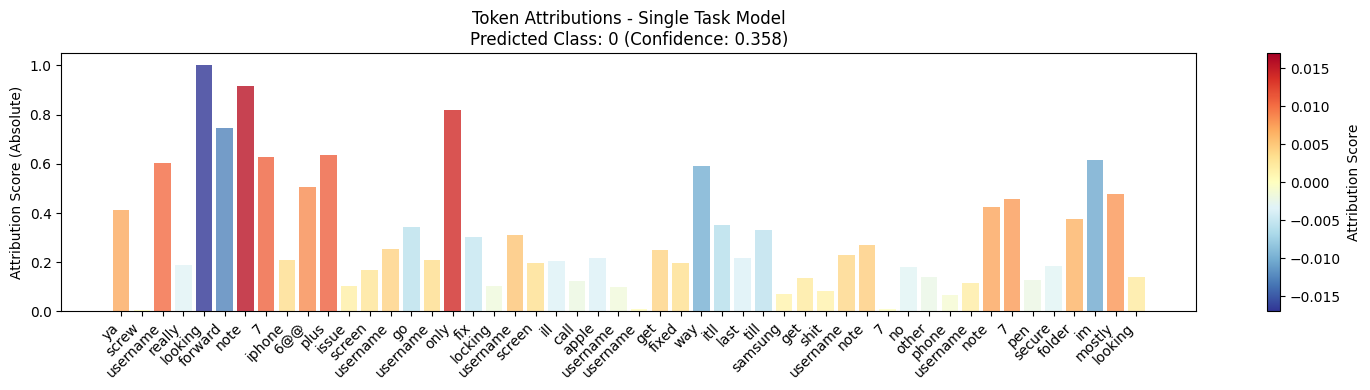

💾 Saved visualization to explainability_results\multitask_example_1.png


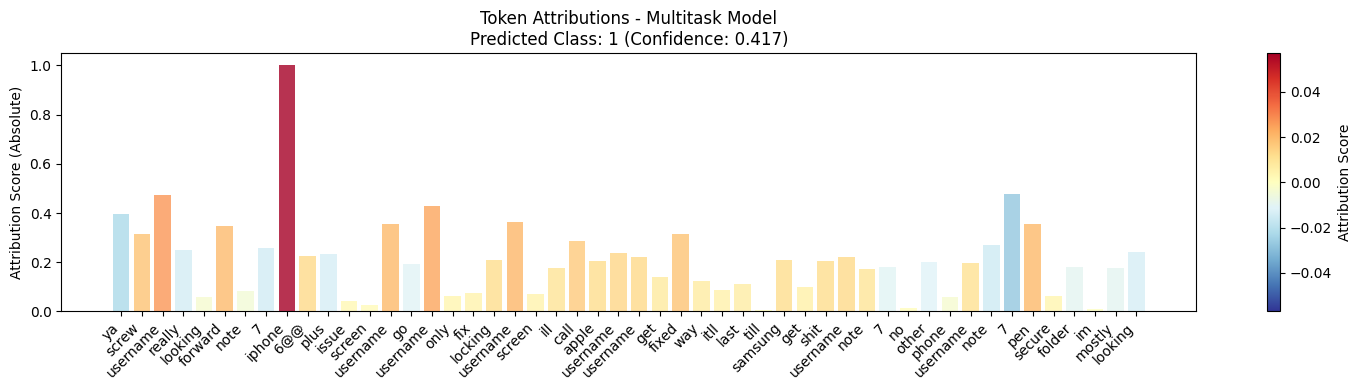

💾 Saved visualization to explainability_results\single_task_example_2.png


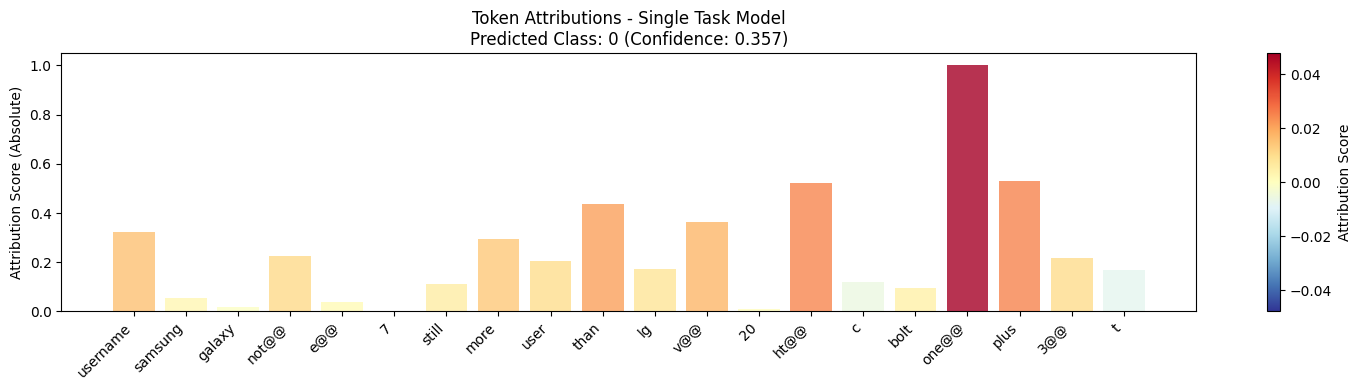

💾 Saved visualization to explainability_results\multitask_example_2.png


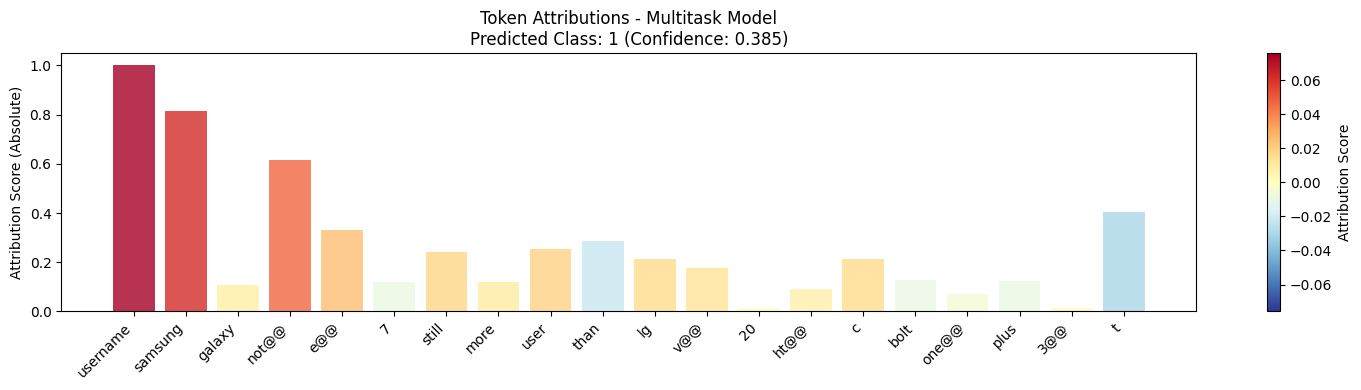

💾 Saved visualization to explainability_results\single_task_example_3.png


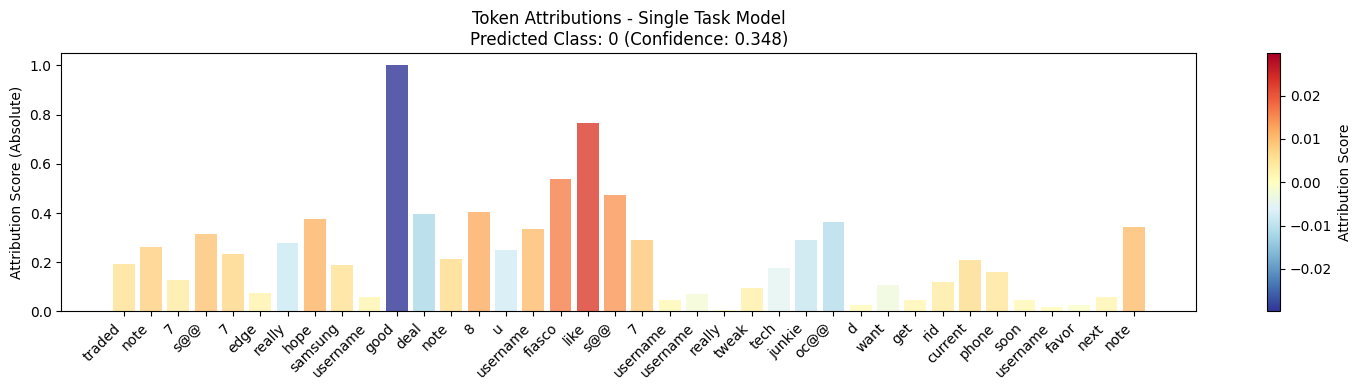

💾 Saved visualization to explainability_results\multitask_example_3.png


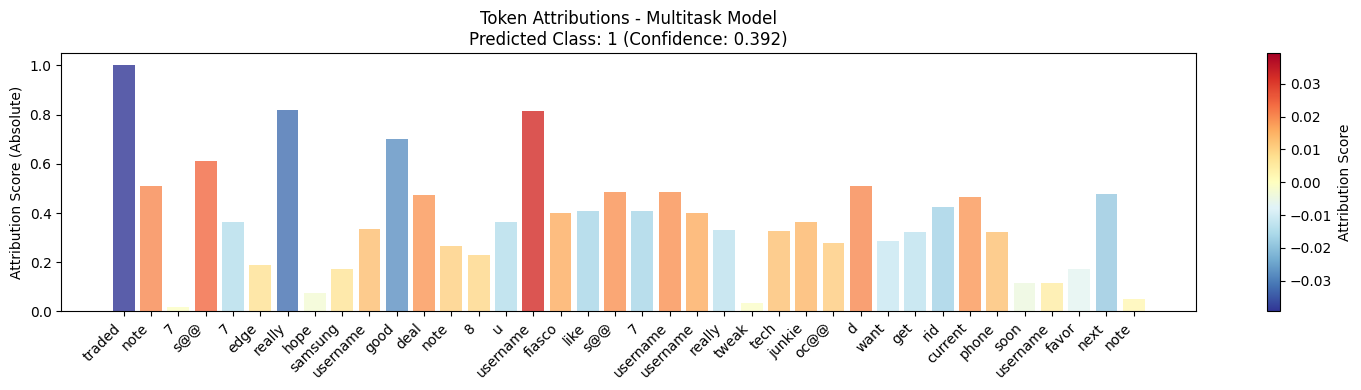

💾 Saved comparison plot to explainability_results\model_comparison.png


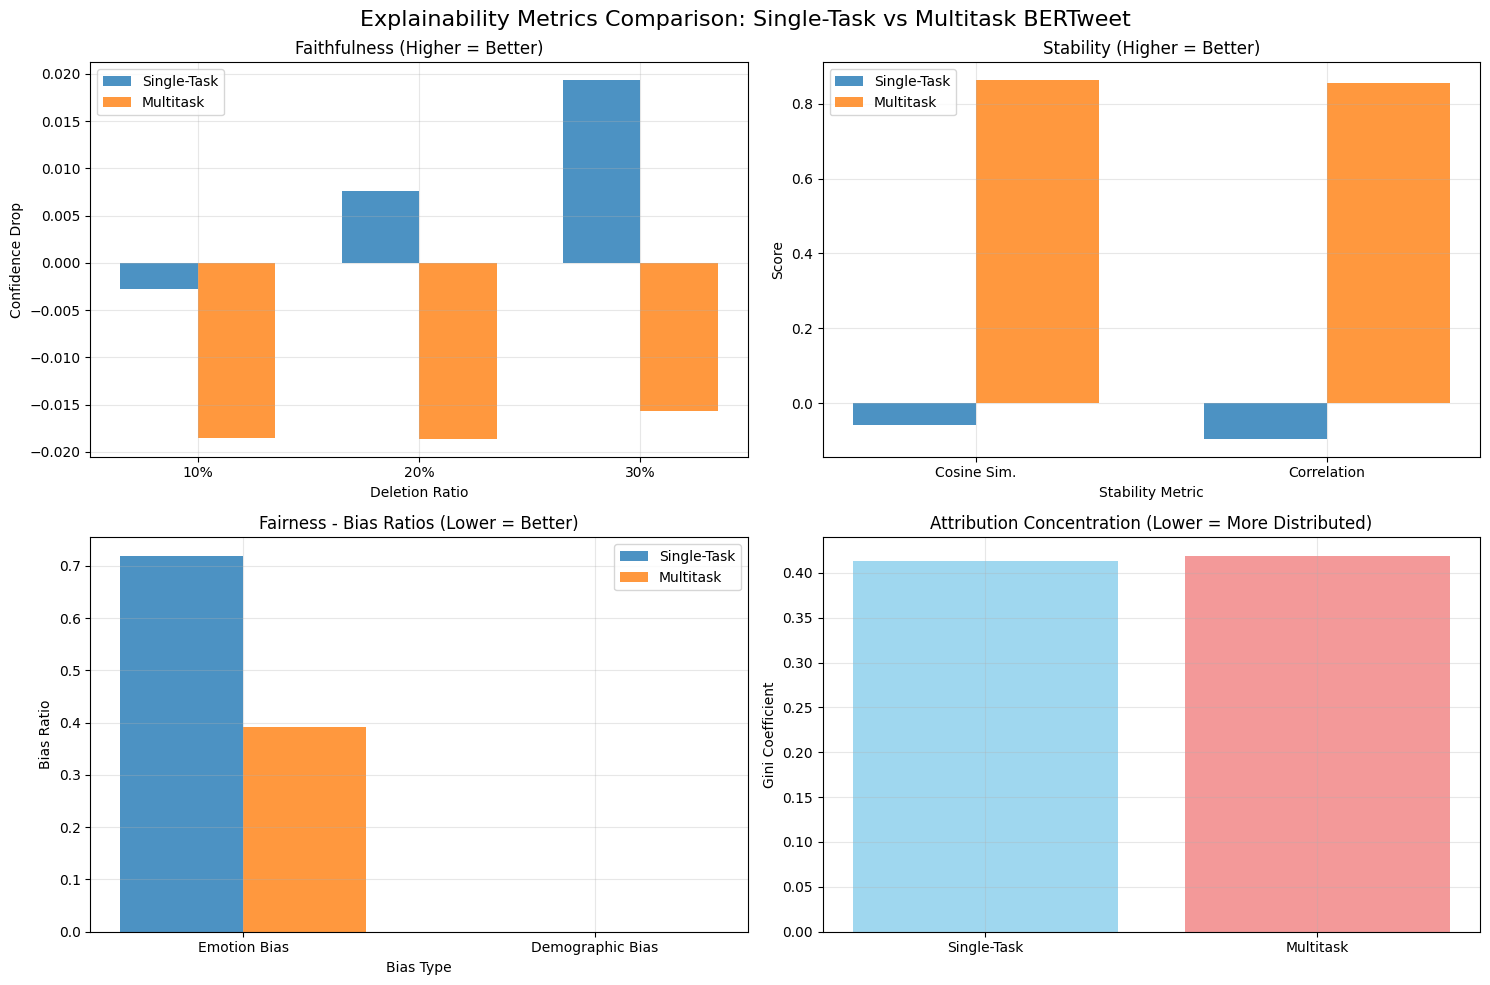

In [ ]:
# Evaluate 
evaluation_results = evaluate_all_explanations(explanations)

# Visualize
step_5_visualize_results(explanations, evaluation_results)

In [110]:
# Report
step_6_generate_report(evaluation_results, "report.txt")

💾 Saved report to report.txt

    🧠 BERTWEET EXPLAINABILITY ANALYSIS REPORT

    📊 ANALYSIS OVERVIEW:
    - Models Compared: Single-Task BERTweet vs Multitask BERTweet (Sentiment Head)
    - Test Examples: 7 examples
    - Explanation Method: Integrated Gradients
    - Evaluation Metrics: Faithfulness, Stability, Fairness

    📈 FAITHFULNESS RESULTS (Confidence drop when removing top 20% tokens):

    Single-Task Model:
    - Mean: 0.0119 ± 0.0154

    Multitask Model:
    - Mean: -0.0186 ± 0.0248

    Interpretation: Higher values indicate more faithful explanations.
    ✅ Single-task model shows higher faithfulness

    🔄 STABILITY RESULTS (Cosine similarity across perturbations):

    Single-Task Model:
    - Mean: -0.0392 ± 0.3426

    Multitask Model:
    - Mean: 0.8859 ± 0.0753

    Interpretation: Higher values indicate more stable explanations.
    ✅ Multitask model shows higher stability

    ⚖️ FAIRNESS RESULTS (Emotion bias ratio):

    Single-Task Model:
    - Mean: 0.7189 

"\n    ================================================================================\n    🧠 BERTWEET EXPLAINABILITY ANALYSIS REPORT\n    ================================================================================\n\n    📊 ANALYSIS OVERVIEW:\n    - Models Compared: Single-Task BERTweet vs Multitask BERTweet (Sentiment Head)\n    - Test Examples: 7 examples\n    - Explanation Method: Integrated Gradients\n    - Evaluation Metrics: Faithfulness, Stability, Fairness\n\n    ================================================================================\n    📈 FAITHFULNESS RESULTS (Confidence drop when removing top 20% tokens):\n\n    Single-Task Model:\n    - Mean: 0.0119 ± 0.0154\n\n    Multitask Model:\n    - Mean: -0.0186 ± 0.0248\n\n    Interpretation: Higher values indicate more faithful explanations.\n    ✅ Single-task model shows higher faithfulness\n\n    ================================================================================\n    🔄 STABILITY RESULTS (Cosine simila